In [4]:
# Install required package
%pip install pyarrow

/home/simon/Desktop/datalit/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

from datalit.data_util import decode_weather_code, categorize_weather

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)


## 1. Load Weather Data

In [6]:
# Load the combined weather dataset
data_path = Path.cwd() / 'data' / 'processed' / 'weather'

# Find the combined CSV file
weather_files = list(data_path.glob('weather_heidelberg_*_combined.csv'))

if not weather_files:
    raise FileNotFoundError("No weather data found. Please run fetch_weather_data.py first.")

weather_file = weather_files[0]
print(f"Loading: {weather_file.name}")

df = pl.read_csv(weather_file)

# Parse datetime if not already done
if 'datetime' not in df.columns:
    df = df.with_columns(
        pl.col('timestamp').str.to_datetime().alias('datetime')
    )

print(f"\nLoaded {len(df):,} weather records")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns: {df.columns}")
df.head()

Loading: weather_heidelberg_2013_2025_combined.csv

Loaded 105,192 weather records
Date range: 2013-01-01T00:00 to 2024-12-31T23:00

Columns: ['timestamp', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'snowfall', 'weather_code', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'datetime', 'year', 'month', 'day', 'hour', 'weekday', 'day_of_year', 'weather_description']


timestamp,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,datetime,year,month,day,hour,weekday,day_of_year,weather_description
str,f64,i64,f64,f64,f64,i64,i64,f64,i64,f64,str,i64,i64,i64,i64,i64,i64,str
"""2013-01-01T00:00""",5.1,65,0.0,0.0,0.0,3,99,17.4,193,31.0,"""2013-01-01T00:00:00.000000""",2013,1,1,0,2,1,"""Overcast"""
"""2013-01-01T01:00""",5.1,63,0.0,0.0,0.0,3,100,17.0,197,31.0,"""2013-01-01T01:00:00.000000""",2013,1,1,1,2,1,"""Overcast"""
"""2013-01-01T02:00""",5.2,62,0.0,0.0,0.0,3,100,17.2,200,31.0,"""2013-01-01T02:00:00.000000""",2013,1,1,2,2,1,"""Overcast"""
"""2013-01-01T03:00""",5.3,62,0.0,0.0,0.0,3,100,18.3,200,32.0,"""2013-01-01T03:00:00.000000""",2013,1,1,3,2,1,"""Overcast"""
"""2013-01-01T04:00""",5.6,62,0.0,0.0,0.0,3,100,19.1,202,33.1,"""2013-01-01T04:00:00.000000""",2013,1,1,4,2,1,"""Overcast"""


## 2. Basic Statistics

In [7]:
# basic summary stats
stats = df.select([
    pl.col('temperature_2m').mean().alias('avg_temp'),
    pl.col('temperature_2m').std().alias('std_temp'),
    pl.col('temperature_2m').min().alias('min_temp'),
    pl.col('temperature_2m').max().alias('max_temp'),
    pl.col('precipitation').sum().alias('total_precip'),
    (pl.col('precipitation') > 0).sum().alias('rain_hours'),
    pl.col('wind_speed_10m').mean().alias('avg_wind'),
    pl.col('wind_speed_10m').max().alias('max_wind'),
    pl.col('relative_humidity_2m').mean().alias('avg_humidity'),
]).to_dicts()[0]

print(f"temp avg {stats['avg_temp']:.1f}°C sd {stats['std_temp']:.1f} range {stats['min_temp']:.1f}–{stats['max_temp']:.1f}")
print(f"precip total {stats['total_precip']:.0f} mm rain hours {stats['rain_hours']}")
print(f"wind avg {stats['avg_wind']:.1f} km/h max {stats['max_wind']:.1f} km/h")
print(f"humidity avg {stats['avg_humidity']:.1f}%")

temp avg 11.8°C sd 7.9 range -14.6–37.8
precip total 10192 mm rain hours 19974
wind avg 10.0 km/h max 44.1 km/h
humidity avg 75.0%


## 3. Temperature Distribution and Trends

/tmp/ipykernel_8061/3956391023.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(temp_by_month, labels=month_names)


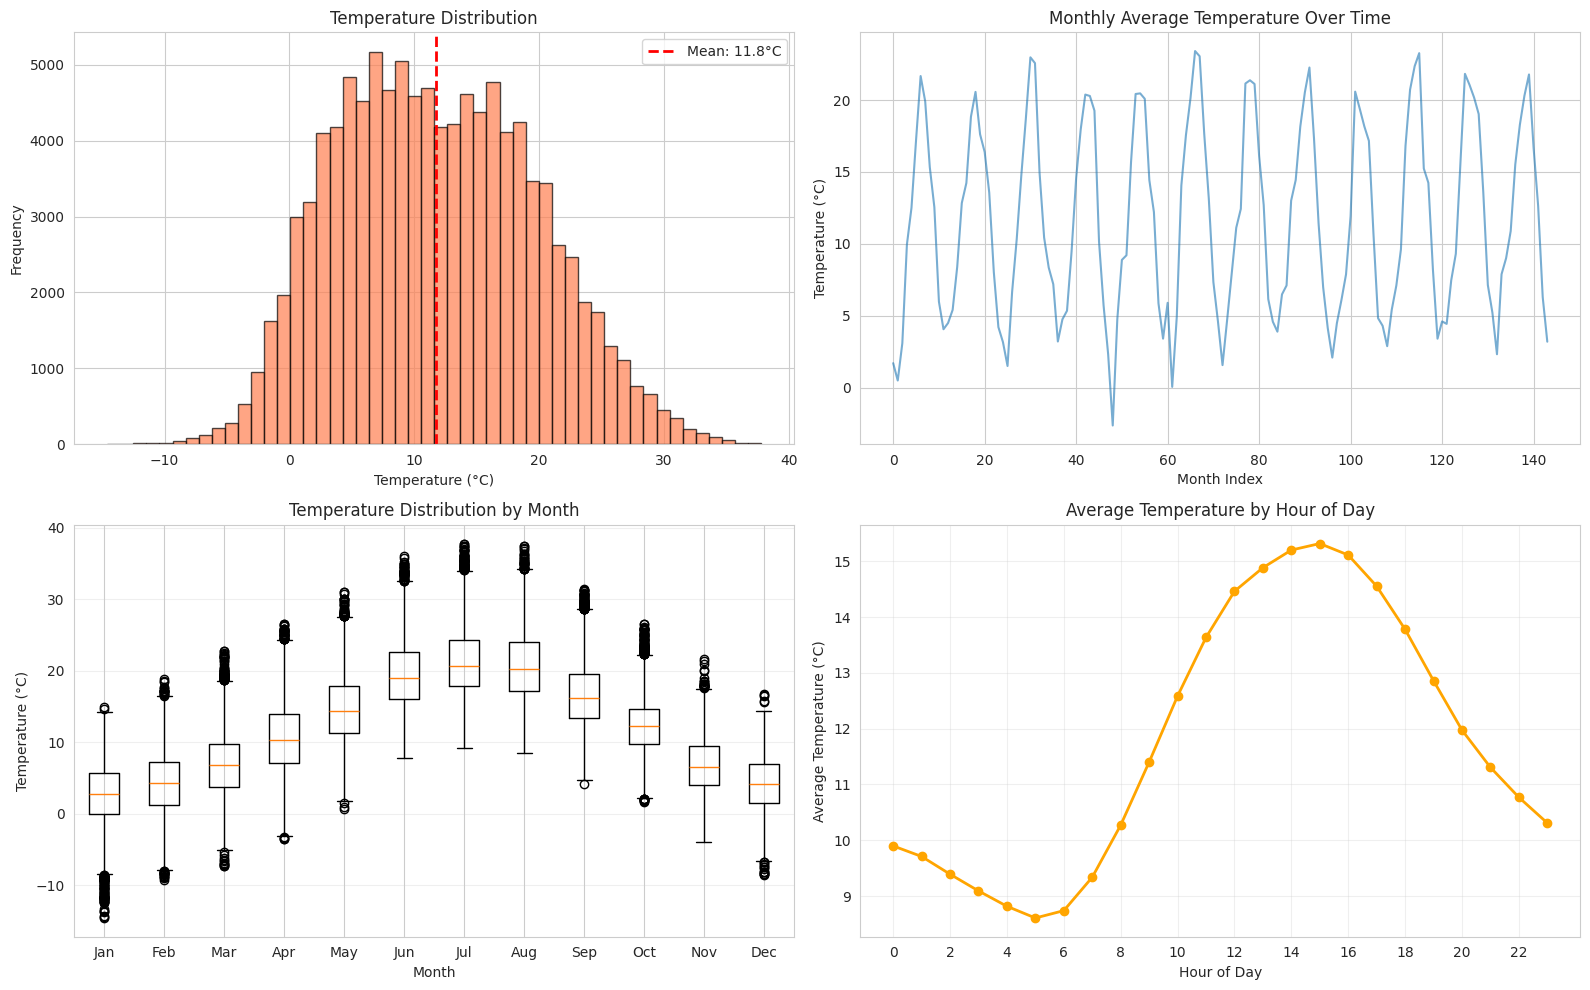

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Temperature distribution
axes[0, 0].hist(df['temperature_2m'].to_numpy(), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Temperature Distribution')
axes[0, 0].axvline(stats['avg_temp'], color='red', linestyle='--', linewidth=2, label=f'Mean: {stats["avg_temp"]:.1f}°C')
axes[0, 0].legend()

# Monthly average temperature
monthly_temp = (
    df.group_by(['year', 'month'])
    .agg(pl.col('temperature_2m').mean())
    .sort(['year', 'month'])
)
axes[0, 1].plot(range(len(monthly_temp)), monthly_temp['temperature_2m'].to_numpy(), alpha=0.6)
axes[0, 1].set_xlabel('Month Index')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_title('Monthly Average Temperature Over Time')

# Seasonal temperature (boxplot by month)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
temp_by_month = [df.filter(pl.col('month') == i)['temperature_2m'].to_numpy() for i in range(1, 13)]
axes[1, 0].boxplot(temp_by_month, labels=month_names)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].set_title('Temperature Distribution by Month')
axes[1, 0].grid(axis='y', alpha=0.3)

# Daily temperature pattern (average by hour)
hourly_temp = (
    df.group_by('hour')
    .agg(pl.col('temperature_2m').mean())
    .sort('hour')
)
axes[1, 1].plot(hourly_temp['hour'], hourly_temp['temperature_2m'], marker='o', linewidth=2, color='orange')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Temperature (°C)')
axes[1, 1].set_title('Average Temperature by Hour of Day')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Precipitation Analysis

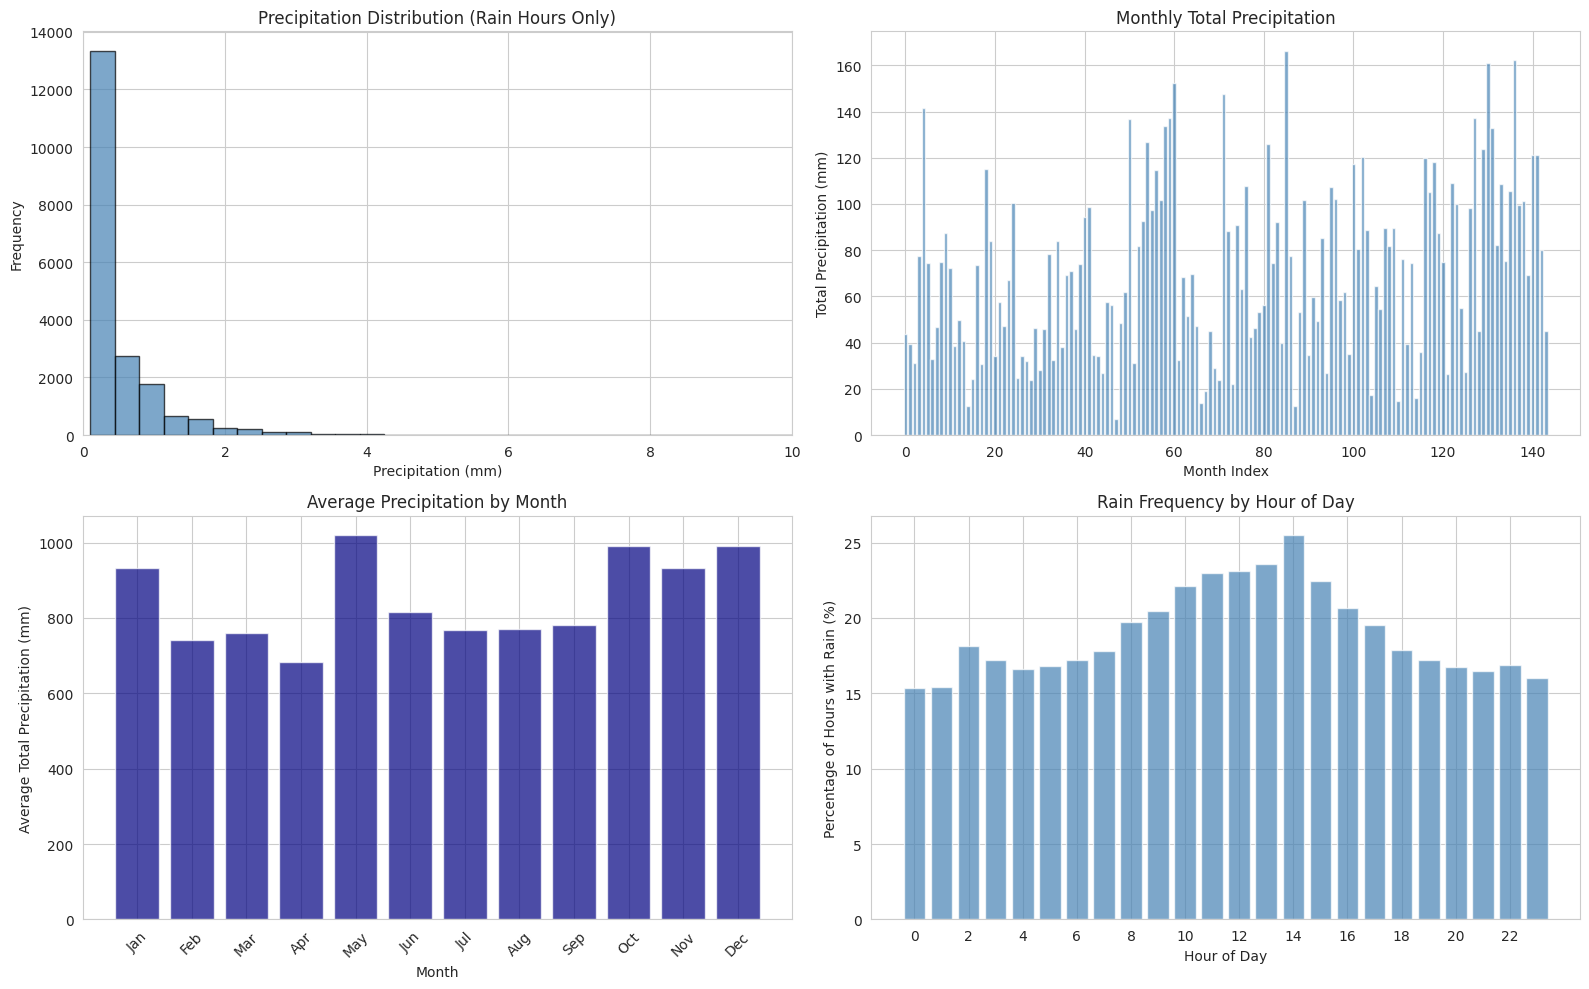


Extreme precipitation events (>5mm/hour): 64

Top 10 heaviest precipitation events:
shape: (10, 3)
┌──────────────────┬───────────────┬────────────────┐
│ timestamp        ┆ precipitation ┆ temperature_2m │
│ ---              ┆ ---           ┆ ---            │
│ str              ┆ f64           ┆ f64            │
╞══════════════════╪═══════════════╪════════════════╡
│ 2024-06-29T22:00 ┆ 17.4          ┆ 22.4           │
│ 2024-08-01T19:00 ┆ 14.4          ┆ 21.5           │
│ 2017-09-13T22:00 ┆ 13.4          ┆ 15.2           │
│ 2023-08-17T01:00 ┆ 12.9          ┆ 19.8           │
│ 2024-07-10T19:00 ┆ 12.6          ┆ 20.7           │
│ 2023-06-22T15:00 ┆ 11.5          ┆ 22.5           │
│ 2020-06-17T13:00 ┆ 9.9           ┆ 20.9           │
│ 2021-07-13T05:00 ┆ 9.8           ┆ 18.1           │
│ 2022-09-10T12:00 ┆ 8.8           ┆ 16.1           │
│ 2017-06-04T05:00 ┆ 8.7           ┆ 16.2           │
└──────────────────┴───────────────┴────────────────┘


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Precipitation distribution (only hours with rain)
rain_data = df.filter(pl.col('precipitation') > 0)['precipitation'].to_numpy()
axes[0, 0].hist(rain_data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Precipitation (mm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Precipitation Distribution (Rain Hours Only)')
axes[0, 0].set_xlim(0, 10)  # Focus on common precipitation levels

# Monthly total precipitation
monthly_precip = (
    df.group_by(['year', 'month'])
    .agg(pl.col('precipitation').sum())
    .sort(['year', 'month'])
)
axes[0, 1].bar(range(len(monthly_precip)), monthly_precip['precipitation'].to_numpy(), alpha=0.7, color='steelblue')
axes[0, 1].set_xlabel('Month Index')
axes[0, 1].set_ylabel('Total Precipitation (mm)')
axes[0, 1].set_title('Monthly Total Precipitation')

# Seasonal precipitation
precip_by_month = [
    df.filter(pl.col('month') == i)['precipitation'].sum() for i in range(1, 13)
]
axes[1, 0].bar(month_names, precip_by_month, color='navy', alpha=0.7)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Total Precipitation (mm)')
axes[1, 0].set_title('Average Precipitation by Month')
axes[1, 0].tick_params(axis='x', rotation=45)

# Rain frequency by hour
rain_by_hour = (
    df.group_by('hour')
    .agg((pl.col('precipitation') > 0).sum().alias('rain_hours'))
    .sort('hour')
)
rain_by_hour = rain_by_hour.with_columns(
    (pl.col('rain_hours') / (len(df) / 24) * 100).alias('rain_percentage')
)
axes[1, 1].bar(rain_by_hour['hour'], rain_by_hour['rain_percentage'], color='steelblue', alpha=0.7)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Percentage of Hours with Rain (%)')
axes[1, 1].set_title('Rain Frequency by Hour of Day')
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

# Extreme precipitation events
extreme_precip = df.filter(pl.col('precipitation') > 5).sort('precipitation', descending=True)
print(f"\nExtreme precipitation events (>5mm/hour): {len(extreme_precip)}")
if len(extreme_precip) > 0:
    print("\nTop 10 heaviest precipitation events:")
    print(extreme_precip.select(['timestamp', 'precipitation', 'temperature_2m']).head(10))

## 5. Wind Analysis

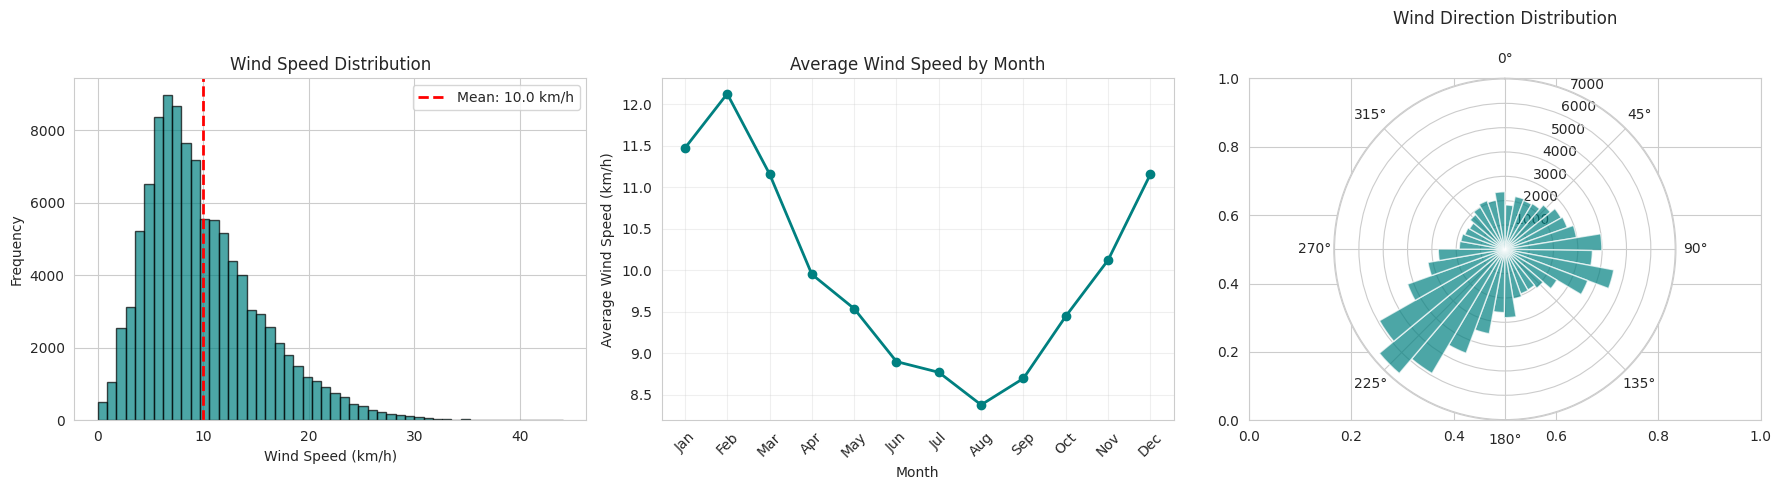


Strong wind events (>30 km/h): 335 (0.3%)


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Wind speed distribution
axes[0].hist(df['wind_speed_10m'].to_numpy(), bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Wind Speed (km/h)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Wind Speed Distribution')
axes[0].axvline(stats['avg_wind'], color='red', linestyle='--', linewidth=2, label=f'Mean: {stats["avg_wind"]:.1f} km/h')
axes[0].legend()

# Wind speed by month
wind_by_month = (
    df.group_by('month')
    .agg(pl.col('wind_speed_10m').mean())
    .sort('month')
)
axes[1].plot(wind_by_month['month'], wind_by_month['wind_speed_10m'], marker='o', linewidth=2, color='teal')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Wind Speed (km/h)')
axes[1].set_title('Average Wind Speed by Month')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

# Wind direction distribution (polar plot)
ax_polar = plt.subplot(133, projection='polar')
wind_dir = df['wind_direction_10m'].to_numpy()
wind_dir_rad = wind_dir * (3.14159 / 180)  # Convert to radians
ax_polar.hist(wind_dir_rad, bins=36, color='teal', alpha=0.7)
ax_polar.set_theta_zero_location('N')
ax_polar.set_theta_direction(-1)
ax_polar.set_title('Wind Direction Distribution', pad=20)

plt.tight_layout()
plt.show()

# Strong wind events
strong_wind = df.filter(pl.col('wind_speed_10m') > 30).sort('wind_speed_10m', descending=True)
print(f"\nStrong wind events (>30 km/h): {len(strong_wind)} ({len(strong_wind)/len(df)*100:.1f}%)")

## 6. Weather Conditions Analysis

Weather Condition Distribution:
Overcast                      :   37,971 hours (36.10%)
Clear sky                     :   21,657 hours (20.59%)
Mainly clear                  :   13,167 hours (12.52%)
Drizzle: Light                :   12,515 hours (11.90%)
Partly cloudy                 :   12,311 hours (11.70%)
Drizzle: Moderate             :    3,543 hours ( 3.37%)
Rain: Slight                  :    1,318 hours ( 1.25%)
Drizzle: Dense intensity      :      922 hours ( 0.88%)
Snow fall: Slight             :      872 hours ( 0.83%)
Snow fall: Moderate           :      450 hours ( 0.43%)
Rain: Moderate                :      409 hours ( 0.39%)
Snow fall: Heavy intensity    :       38 hours ( 0.04%)
Rain: Heavy intensity         :       19 hours ( 0.02%)


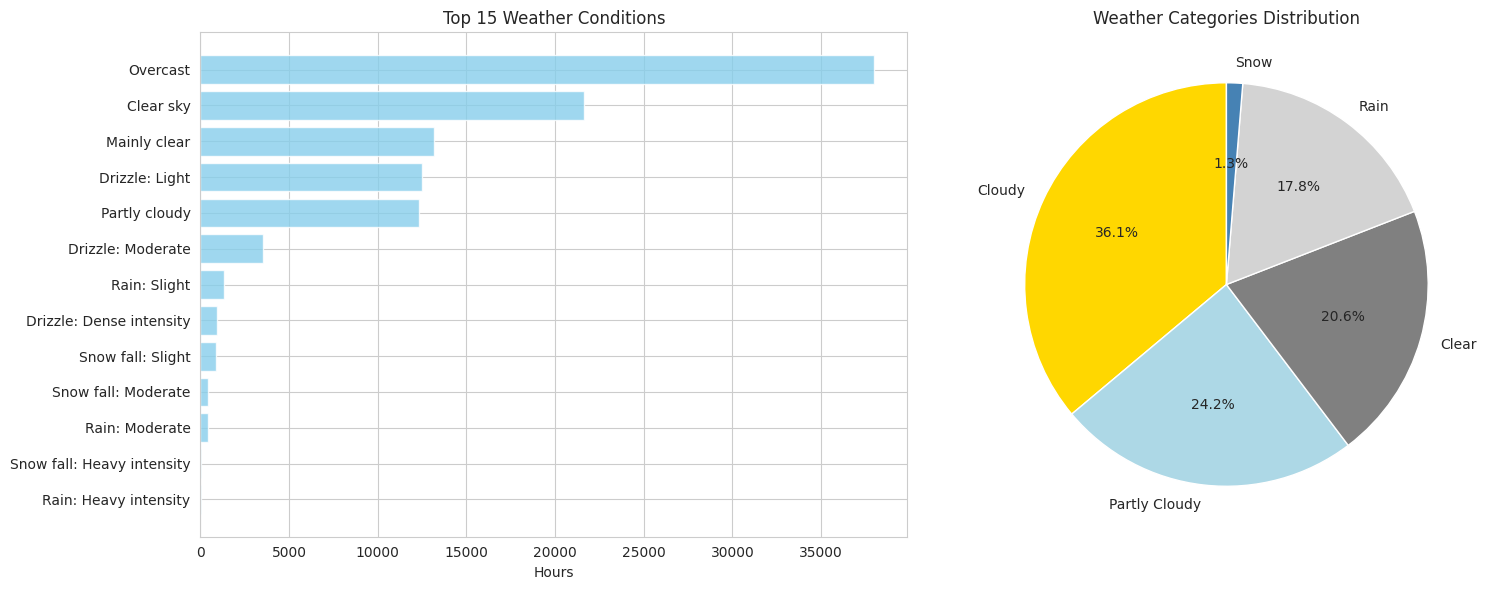

In [11]:
# Weather condition distribution
weather_dist = (
    df.group_by('weather_description')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
)

print("Weather Condition Distribution:")
print("=" * 60)
for row in weather_dist.iter_rows(named=True):
    percentage = (row['count'] / len(df)) * 100
    print(f"{row['weather_description']:30s}: {row['count']:8,} hours ({percentage:5.2f}%)")

# Visualize top weather conditions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top 15 conditions
top_weather = weather_dist.head(15)
axes[0].barh(range(len(top_weather)), top_weather['count'].to_numpy(), color='skyblue', alpha=0.8)
axes[0].set_yticks(range(len(top_weather)))
axes[0].set_yticklabels(top_weather['weather_description'].to_list())
axes[0].set_xlabel('Hours')
axes[0].set_title('Top 15 Weather Conditions')
axes[0].invert_yaxis()

# Add weather categories
if 'weather_description' in df.columns:
    df_with_cat = df.with_columns(
        pl.col('weather_code').map_elements(categorize_weather, return_dtype=pl.String).alias('weather_category')
    )
    
    cat_dist = (
        df_with_cat.group_by('weather_category')
        .agg(pl.len().alias('count'))
        .sort('count', descending=True)
    )
    
    # Pie chart of categories
    colors = ['gold', 'lightblue', 'gray', 'lightgray', 'steelblue', 'white', 'purple', 'pink']
    axes[1].pie(
        cat_dist['count'].to_numpy(),
        labels=cat_dist['weather_category'].to_list(),
        autopct='%1.1f%%',
        colors=colors[:len(cat_dist)],
        startangle=90
    )
    axes[1].set_title('Weather Categories Distribution')

plt.tight_layout()
plt.show()

## 7. Correlation Matrix

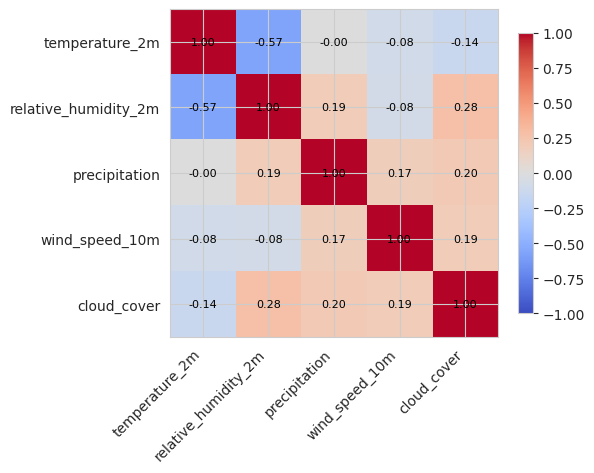

notable correlations (>|0.3|):
temperature_2m vs relative_humidity_2m: -0.57


In [12]:
# correlation using polars directly
numeric_cols = [
    'temperature_2m',
    'relative_humidity_2m',
    'precipitation',
    'wind_speed_10m',
    'cloud_cover'
]

corr_df = df.select(numeric_cols).corr()
# corr_df is square matrix; convert to numpy for plotting
mat = corr_df.select(numeric_cols).to_numpy()  # rows align with columns

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(mat, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols)
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        ax.text(j, i, f"{mat[i, j]:.2f}", ha='center', va='center', color='black', fontsize=8)
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

print("notable correlations (>|0.3|):")
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        val = mat[i, j]
        if abs(val) > 0.3:
            print(f"{numeric_cols[i]} vs {numeric_cols[j]}: {val:.2f}")

## 8. Extreme Weather Events

In [13]:
print("EXTREME WEATHER EVENTS")
print("=" * 70)

# Define extreme conditions
extreme_cold = df.filter(pl.col('temperature_2m') < -5)
extreme_hot = df.filter(pl.col('temperature_2m') > 35)
heavy_rain = df.filter(pl.col('precipitation') > 5)
strong_wind = df.filter(pl.col('wind_speed_10m') > 40)

print(f"\nExtreme Cold (<-5°C): {len(extreme_cold):,} hours ({len(extreme_cold)/len(df)*100:.2f}%)")
if len(extreme_cold) > 0:
    print(f"  Coldest: {extreme_cold['temperature_2m'].min():.1f}°C on {extreme_cold.sort('temperature_2m').head(1)['timestamp'][0]}")

print(f"\nExtreme Heat (>35°C): {len(extreme_hot):,} hours ({len(extreme_hot)/len(df)*100:.2f}%)")
if len(extreme_hot) > 0:
    print(f"  Hottest: {extreme_hot['temperature_2m'].max():.1f}°C on {extreme_hot.sort('temperature_2m', descending=True).head(1)['timestamp'][0]}")

print(f"\nHeavy Rain (>5mm/h): {len(heavy_rain):,} hours ({len(heavy_rain)/len(df)*100:.2f}%)")
if len(heavy_rain) > 0:
    print(f"  Heaviest: {heavy_rain['precipitation'].max():.1f}mm on {heavy_rain.sort('precipitation', descending=True).head(1)['timestamp'][0]}")

print(f"\nStrong Wind (>40km/h): {len(strong_wind):,} hours ({len(strong_wind)/len(df)*100:.2f}%)")
if len(strong_wind) > 0:
    print(f"  Strongest: {strong_wind['wind_speed_10m'].max():.1f}km/h on {strong_wind.sort('wind_speed_10m', descending=True).head(1)['timestamp'][0]}")

# Combined extreme conditions
extreme_multi = df.filter(
    (pl.col('temperature_2m') < 0) & 
    (pl.col('precipitation') > 1) & 
    (pl.col('wind_speed_10m') > 30)
)
print(f"\nMulti-factor extreme conditions (cold + rain + wind): {len(extreme_multi):,} hours ({len(extreme_multi)/len(df)*100:.2f}%)")

EXTREME WEATHER EVENTS

Extreme Cold (<-5°C): 557 hours (0.53%)
  Coldest: -14.6°C on 2017-01-23T07:00

Extreme Heat (>35°C): 65 hours (0.06%)
  Hottest: 37.8°C on 2019-07-25T14:00

Heavy Rain (>5mm/h): 64 hours (0.06%)
  Heaviest: 17.4mm on 2024-06-29T22:00

Strong Wind (>40km/h): 13 hours (0.01%)
  Strongest: 44.1km/h on 2019-03-04T16:00

Multi-factor extreme conditions (cold + rain + wind): 0 hours (0.00%)


## 9. Seasonal Analysis


SEASONAL STATISTICS
shape: (4, 6)
┌────────┬───────────┬──────────────┬───────────┬──────────────┬───────┐
│ season ┆ avg_temp  ┆ total_precip ┆ avg_wind  ┆ avg_humidity ┆ hours │
│ ---    ┆ ---       ┆ ---          ┆ ---       ┆ ---          ┆ ---   │
│ str    ┆ f64       ┆ f64          ┆ f64       ┆ f64          ┆ u32   │
╞════════╪═══════════╪══════════════╪═══════════╪══════════════╪═══════╡
│ Spring ┆ 10.709443 ┆ 2463.1       ┆ 10.218135 ┆ 70.650325    ┆ 26496 │
│ Summer ┆ 20.535262 ┆ 2355.8       ┆ 8.677495  ┆ 66.080389    ┆ 26496 │
│ Autumn ┆ 11.889595 ┆ 2706.7       ┆ 9.41996   ┆ 79.89072     ┆ 26208 │
│ Winter ┆ 3.71662   ┆ 2666.0       ┆ 11.568948 ┆ 83.639928    ┆ 25992 │
└────────┴───────────┴──────────────┴───────────┴──────────────┴───────┘


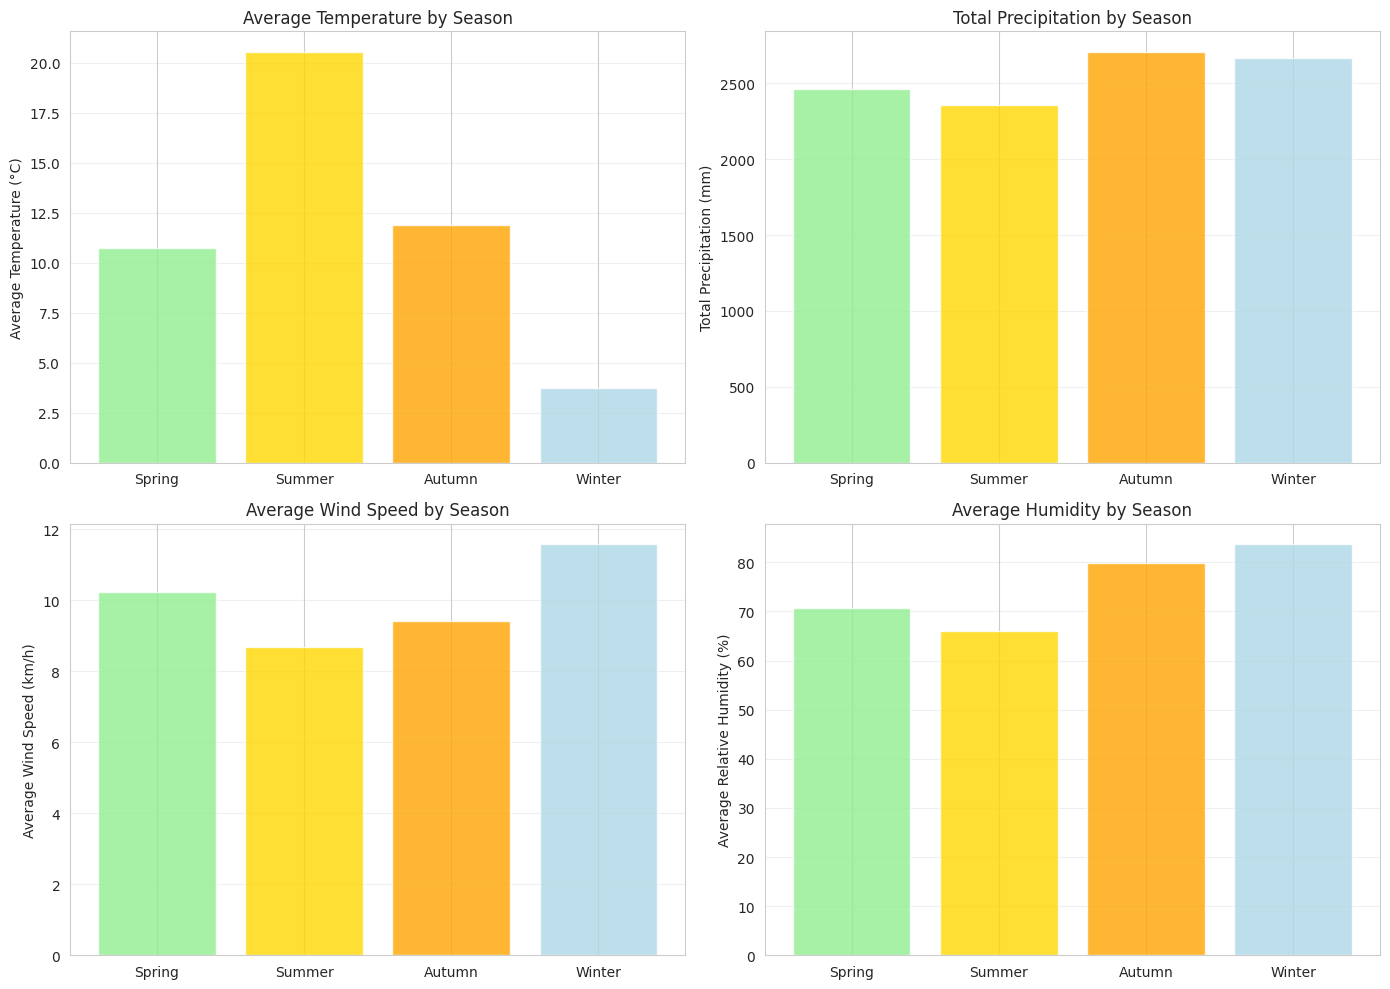

In [14]:
# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_seasonal = df.with_columns(
    pl.col('month').map_elements(get_season, return_dtype=pl.String).alias('season')
)

# Seasonal statistics
seasonal_stats = df_seasonal.group_by('season').agg([
    pl.col('temperature_2m').mean().alias('avg_temp'),
    pl.col('precipitation').sum().alias('total_precip'),
    pl.col('wind_speed_10m').mean().alias('avg_wind'),
    pl.col('relative_humidity_2m').mean().alias('avg_humidity'),
    pl.len().alias('hours')
])

# Sort by season order
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_stats = seasonal_stats.sort(
    pl.col('season').map_elements(lambda x: season_order.index(x), return_dtype=pl.Int32)
)

print("\nSEASONAL STATISTICS")
print("=" * 70)
print(seasonal_stats)

# Visualize seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

seasons = seasonal_stats['season'].to_list()
colors_season = ['lightgreen', 'gold', 'orange', 'lightblue']

# Temperature by season
axes[0, 0].bar(seasons, seasonal_stats['avg_temp'], color=colors_season, alpha=0.8)
axes[0, 0].set_ylabel('Average Temperature (°C)')
axes[0, 0].set_title('Average Temperature by Season')
axes[0, 0].grid(axis='y', alpha=0.3)

# Precipitation by season
axes[0, 1].bar(seasons, seasonal_stats['total_precip'], color=colors_season, alpha=0.8)
axes[0, 1].set_ylabel('Total Precipitation (mm)')
axes[0, 1].set_title('Total Precipitation by Season')
axes[0, 1].grid(axis='y', alpha=0.3)

# Wind by season
axes[1, 0].bar(seasons, seasonal_stats['avg_wind'], color=colors_season, alpha=0.8)
axes[1, 0].set_ylabel('Average Wind Speed (km/h)')
axes[1, 0].set_title('Average Wind Speed by Season')
axes[1, 0].grid(axis='y', alpha=0.3)

# Humidity by season
axes[1, 1].bar(seasons, seasonal_stats['avg_humidity'], color=colors_season, alpha=0.8)
axes[1, 1].set_ylabel('Average Relative Humidity (%)')
axes[1, 1].set_title('Average Humidity by Season')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Export Aggregated Data for Further Analysis

In [15]:
# daily aggregates for merge
if df['datetime'].dtype == pl.String:
    df = df.with_columns(pl.col('datetime').str.to_datetime().alias('datetime'))

daily_weather = (
    df.with_columns(pl.col('datetime').dt.date().alias('date'))
      .group_by('date')
      .agg([
          pl.col('temperature_2m').mean().alias('avg_temp'),
          pl.col('temperature_2m').min().alias('min_temp'),
          pl.col('temperature_2m').max().alias('max_temp'),
          pl.col('precipitation').sum().alias('total_precip'),
          (pl.col('precipitation') > 0).sum().alias('rain_hours'),
          pl.col('wind_speed_10m').mean().alias('avg_wind'),
          pl.col('wind_speed_10m').max().alias('max_wind'),
          pl.col('relative_humidity_2m').mean().alias('avg_humidity'),
          pl.col('cloud_cover').mean().alias('avg_cloud'),
      ])
      .sort('date')
)

out_path = Path.cwd().parent.parent / 'data' / 'processed' / 'weather' / 'daily_weather_heidelberg.csv'
daily_weather.write_csv(out_path)
print(f"saved daily weather -> {out_path}")
print(f"days {len(daily_weather)} range {daily_weather['date'].min()} .. {daily_weather['date'].max()}")

daily_weather.head(5)

FileNotFoundError: No such file or directory (os error 2): /home/simon/data/processed/weather/daily_weather_heidelberg.csv

## Summary

Core observations:
- Summer warmer peaks; winter dips as expected.
- Rain spread through the year; no single heavy concentration.
- Wind mostly moderate; occasional stronger gusts.
- Few extreme cold / heat hours.

Next:
- Join with bicycle counts (by date/hour) to test weather impact.
- Check rain vs volume drop and temperature elasticity.
- Optionally merge accidents to see if severe weather correlates.
